# EECE 5644 Intro to Machine Learning Homework 4

## Question 1

In this exercise, you will train many multilayer perceptrons (MLP) to approximate the class
label posteriors, using maximum likelihood parameter estimation (equivalently, with minimum
average cross-entropy loss) to train the MLP. Then, you will use the trained models to approximate
a MAP classification rule in an attempt to achieve minimum probability of error (i.e. to minimize
expected loss with 0-1 loss assignments to correct-incorrect decisions).

### **Data Distribution**

For $C=4$ classes with uniform priors, specify Gaussian class-conditional pdfs for a 3-dimensional real-valued random vector $\mathbf{x}$ (pick your own mean vectors and covariance matrices for each class). Try to adjust the parameters so that the MAP classifier achieves between $10\%{-}20\%$ probability of error.

The parameters I am using for the GMM are listed below:

$$ $$ 

\begin{align*} \boldsymbol{\mu}_0 = \begin{bmatrix} -4\\ 0\\0 \end{bmatrix}, \quad \quad \boldsymbol{\Sigma}_0 =\begin{bmatrix}1 & 0.2 & 1.5 \\ 0.2 & 1 & 0.2 \\ 1.5 & 0.2 & 8\end{bmatrix}, \quad & \quad \boldsymbol{\mu}_1 =\begin{bmatrix}-2\\0\\0\end{bmatrix}, \quad \quad \boldsymbol{\Sigma}_1 =\begin{bmatrix}1 & -0.5 & -0.75 \\-0.5 & 1 & -0.5 \\ -0.75 & -0.5 & 5\end{bmatrix} ,\\ \boldsymbol{\mu}_2 = \begin{bmatrix}2\\0\\0\end{bmatrix}, \quad \quad \boldsymbol{\Sigma}_2 =\begin{bmatrix}1 & 0.5 & 0.75 \\0.5 & 1 & 0.5 \\ 0.75 & 0.5 & 5\end{bmatrix}, \quad & \quad \boldsymbol{\mu}_3 = \ \ \begin{bmatrix}4\\0\\0\end{bmatrix}, \quad \quad \ \boldsymbol{\Sigma}_3 =\begin{bmatrix}1 & -0.2 & -1.5 \\ -0.2 & 1 & -0.2 \\ -1.5 & -0.2 & 8\end{bmatrix}, \end{align*}

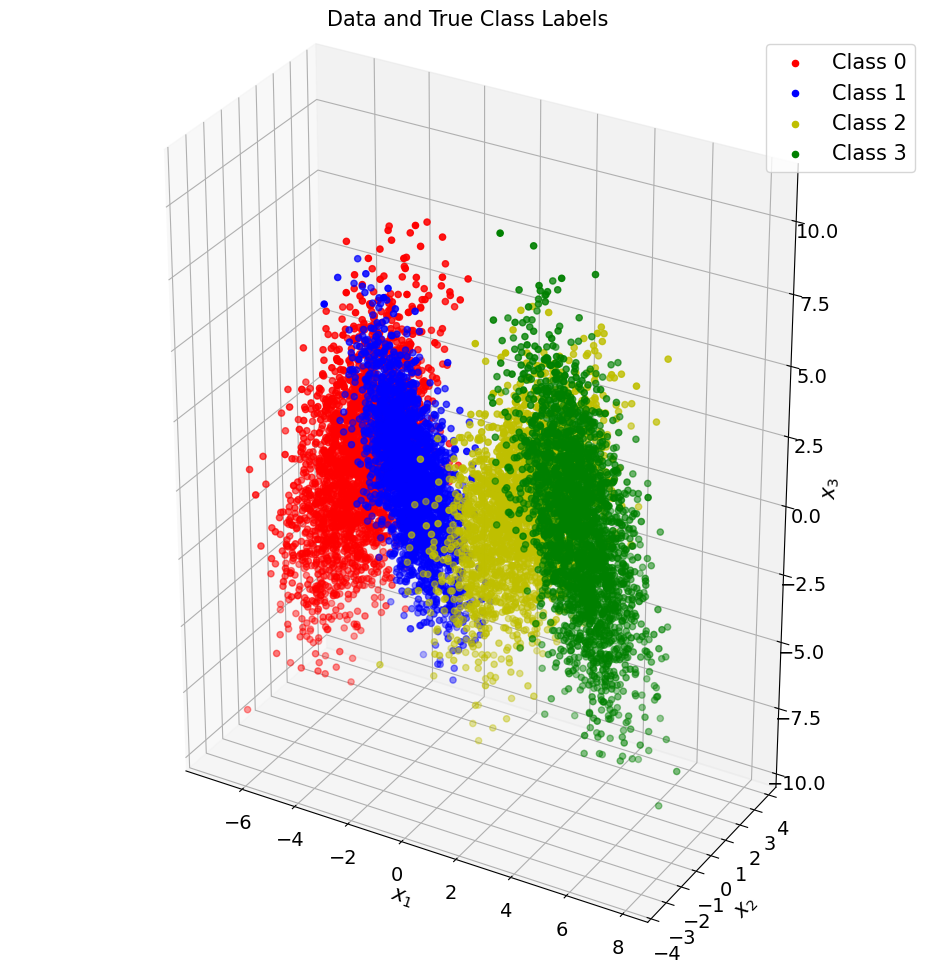

In [3]:
# Generate dataset to test out the four 3D multivariate Gaussian distributions
N = 10000

# Number of classes
C = 4

gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.ones(C) / C  # uniform prior
num_classes = len(gmm_pdf['priors'])
# Mean and covariance of data pdfs conditioned on labels
gmm_pdf['mu'] = np.array([[-4, 0, 0],
                          [-2, 0, 0],
                          [2, 0, 0],
                          [4, 0, 0]])  # Gaussian distributions means
gmm_pdf['Sigma'] = np.array([[[1, .2, 1.5],
                              [.2, 1, .2],
                              [1.5, .2, 8]],
                             [[1, -.5, -.75],
                              [-.5, 1, -.5],
                              [-.75, -.5, 5]],
                             [[1, .5, .75],
                              [.5, 1, .5],
                              [.75, .5, 5]],
                             [[1, -.2, -1.5],
                              [-.2, 1, -.2],
                              [-1.5, -.2, 8]]])  # Gaussian distributions covariance matrices

# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')

X, labels = generate_gmm(N, gmm_pdf)

ax.scatter(X[labels == 0, 0], X[labels == 0, 1], X[labels == 0, 2], c='r', label="Class 0")
ax.scatter(X[labels == 1, 0], X[labels == 1, 1], X[labels == 1, 2], c='b', label="Class 1")
ax.scatter(X[labels == 2, 0], X[labels == 2, 1], X[labels == 2, 2], c='y', label="Class 2")
ax.scatter(X[labels == 3, 0], X[labels == 3, 1], X[labels == 3, 2], c='g', label="Class 3")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_zlabel(r"$x_3$")
# Set equal axes for 3D plots
ax.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(X[:, 2])))

plt.title("Data and True Class Labels")
plt.legend()
plt.tight_layout()

### **MLP Structure**

Use a 2-layer MLP (one hidden layer of perceptrons) that has $P$ perceptrons in the first (hidden) layer with smooth-ramp style activation functions (e.g., Smooth-ReLU, ELU, etc). At the second/output layer use a softmax function to ensure all outputs are positive and sum up to 1 (representing $C$ probabilities). The best number of perceptrons, $P^*$, for your custom problem will be selected using $K$-fold cross-validation.

Create a new class for the 2-Layer MLP using the Pytorch module, initialize the perceptrons such that they create weights and biases that connect to the output layer that is one of the four classes of gaussian components which are connected via a feedforward architecture  
  
For this Neural Network architecture, I am choosing to use the Smooth-ReLU or Softplus activation function , $f(x) = \log(1+e^x)$, in the hidden layer for each node

In [4]:
# Two-layer neural network class
class TwoLayerMLP(nn.Module):
    # call initialization methods for parent class
    def __init__(self, n, P, C):
        super(TwoLayerMLP, self).__init__()
        # Fully connected layer WX + b mapping from n -> P
        self.input_fc = nn.Linear(n, P)
        # Output layer again fully connected mapping from P -> C
        self.output_fc = nn.Linear(P, C)
    # define the forward path that connects weights and biases to output layer   
    def forward(self, input):
        # input is fully connected to activation function
        input = self.input_fc(input)
        # ReLU activation function
        input = F.softplus(input)
        # output connected to ReLU activation function
        output = self.output_fc(input)
        return output

### **Generate Data**

Using your specified data distribution, generate multiple datasets: Training datasets with 100, 200, 500, 1000, 2000, 5000 samples and a test set with 100000 samples. You will use the test dataset only for performance evaluation.

In [5]:
# Number of training sample sets specified in HW document
N_train = [100, 200, 500, 1000, 2000, 5000]
# Number of test samples set specified in HW document
N_test = 100000

# Contain all the generated training sets, their corresponding labels, and the target vectors as lists
X_train = []
y_train = []
for N_i in N_train:
    # Generate all training sets in loop
    X_i, y_i = generate_gmm(N_i, gmm_pdf)

    # Append each training set and target vectors to separate lists
    X_train.append(X_i)
    y_train.append(y_i)

# Generate the testing input samples and target vector using data-generating function
X_test, y_test = generate_gmm(N_test, gmm_pdf)

### **Theoretically Optimal Classifier**

Using your knowledge of the true data pdf, construct the minimum-probability-of-error classifier rule, apply it on the test dataset and empirically estimate the probability of error for this theoretically optimal classifier. This provides the aspirational performance level for the MLP classifier.  

Because all components of the Gaussian Mixture Model has uniform priors, the MAP classifier reduces to a maximum likelihood (ML) classifier:

$$\hat{y} =  \underset{j \in {1, \ldots, C}} {\mathrm{argmax}} \ p(\mathbf{x}|y=j)$$

In [6]:
# Conditional likelihoods of each component
class_cond_likelihoods = np.array([mvn.pdf(X_test, gmm_pdf['mu'][i], gmm_pdf['Sigma'][i]) for i in range(C)])
# Decisions based on argmax to determine which C class
decisions = np.argmax(class_cond_likelihoods, axis=0)
# Evaluate the number of misclassified samples using the test target vector generated previously
misclassified = sum(decisions != y_test)
# Min P(error) is number of misclassified samples divided by number of test samples (100,000)
min_prob_error = (misclassified / N_test)
print("Probability of Error on Test Set using the True Data PDF: {:.4f}".format(min_prob_error))

Probability of Error on Test Set using the True Data PDF: 0.1476


### **Model Order Selection**

For each of the training sets with a different number of samples, perform 10-fold cross-validation using minimum classification error probability as the objective function to select the best number of perceptrons $P$ (as justified by available training data).  

Below are two defined functions that implement generic training/evaluation routines using a Pytorch.nn model

In [7]:
def model_train(model, data, labels, optimizer, criterion=nn.CrossEntropyLoss(), num_epochs=100):
    # train the particular model passed as input
    model.train()
    # Optimize model based on number of epochs specified
    for epoch in range(num_epochs):
        # Get each model's prediction scores 
        outputs = model(data)
        # Compute the cross entropy loss between the model predictions and true pdf labels
        loss = criterion(outputs, labels)
        # Initalize gradient buffers to zero prior to backpropagation
        optimizer.zero_grad()
        # Backpropagation to compute gradient descent
        loss.backward()
        # Step update for gradient descent
        optimizer.step()
        
    return model, loss

def model_predict(model, data):
    # evaluate the model passed as input
    model.eval()
    # Disable gradient descent calculation since we areusing feed-forward pass
    with torch.no_grad():
        # Make predictions from test data
        predicted_labels = model(data)
        # Convert from torch.nn to numpy for comparison with true pdf labels
        predicted_labels = predicted_labels.detach().numpy()
        # ML classifier results from argmax of predicted labels
        return np.argmax(predicted_labels, 1)

In order to perform 10-fold Cross-Validation on the testing set. The samples are partitioned into 10 different datasets for training across the 6 different models we are using to train. Each model will output a range of accuracy scores from the 10-fold cross-validation and then the average of these scores will be taken for each model. The model that performs the best will have the largest average accuracy or similarily we could examine the model that has the smallest average error rate. 
The optimal model $\hat{m}$ will then meet the criteria of 

$$\hat{m} =  \underset{m \in {1, \ldots, M}} {\mathrm{argmin}} \ \epsilon_m$$  

where $M = 6$ for the number of training models and $\epsilon_m$ is the model's average error rate

The next section establishes a function that implements this procedure of operations and ultimately selects the optimal number of perceptrons $\hat{P}$ as the choice of best model $\hat{m}$. Within the cross-validation algorithm, our previous model training and evaluation methods are applied to acquire the maximum likelihood estimate of the parameters for an MLP with a configured $P$, as well as perform predictions using this network on the validation fold.

In [8]:
def k_fold_compute_P(K, P_list, data, labels):
    # Use KFold object to establish 10-Fold Cross-Validation
    kf = KFold(n_splits=K, shuffle=True) 

    # Preallocate memory for error rates across all models
    error_valid_mk = np.zeros((len(P_list), K)) 

    # Iterate over NN options based on # of nodes
    # Track model idx from 0 - 5
    m = 0
    for P in P_list:
        # K-fold cross validation
        k = 0
        for train_idx, valid_idx in kf.split(data):
            # Use K-Fold Split to keep track of the training/testing sets
            # Necessary to convert numpy structure into Tensor datatypes
            X_train_k = torch.FloatTensor(data[train_idx])
            y_train_k = torch.LongTensor(labels[train_idx])

            # Use the 2-Layer MLP class created previously
            model = TwoLayerMLP(X_train_k.shape[1], P, C)

            # Use Stochastic Gradient Descent as optimizer with Learning Rate of 0.1 and Momentum = 0.9
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            
            # Get the Trained model
            model, _ = model_train(model, X_train_k, y_train_k, optimizer)

            # Get the valid samples and convert to Tensor datatypes for predictions
            X_valid_k = torch.FloatTensor(data[valid_idx])
            y_valid_k = labels[valid_idx]
            
            # Perform predictions using the Trained Model
            predictions = model_predict(model, X_valid_k)
            # Save error rate estimates for current model
            error_valid_mk[m, k] = np.sum(predictions != y_valid_k) / len(y_valid_k)
            k += 1
        m += 1
    
    # Compute the average P(error) across 10-fold for the current model
    avg_error_m = np.mean(error_valid_mk, axis=1) 
    
    # Return the optimal value of P that is associated with argmin of average error for model 
    optimal_P = P_list[np.argmin(avg_error_m)]
    
    return optimal_P, avg_error_m

Now we perform 10-Fold Cross-Validation and use the above function to compute the optimal value $\hat{P}$ for each training model  

Note: In order to test varying values for $P$ perceptrons, a 2-based logarithmic range of values were considered {2,4,8,16,32,64,128,256}

	# of Training Samples 	Best # of Perceptrons 	 P(error)
		 100 			 48 		  0.160
		 200 			 256 		  0.135
		 500 			 128 		  0.158
		 1000 			 256 		  0.168
		 2000 			 256 		  0.170
		 5000 			 256 		  0.150


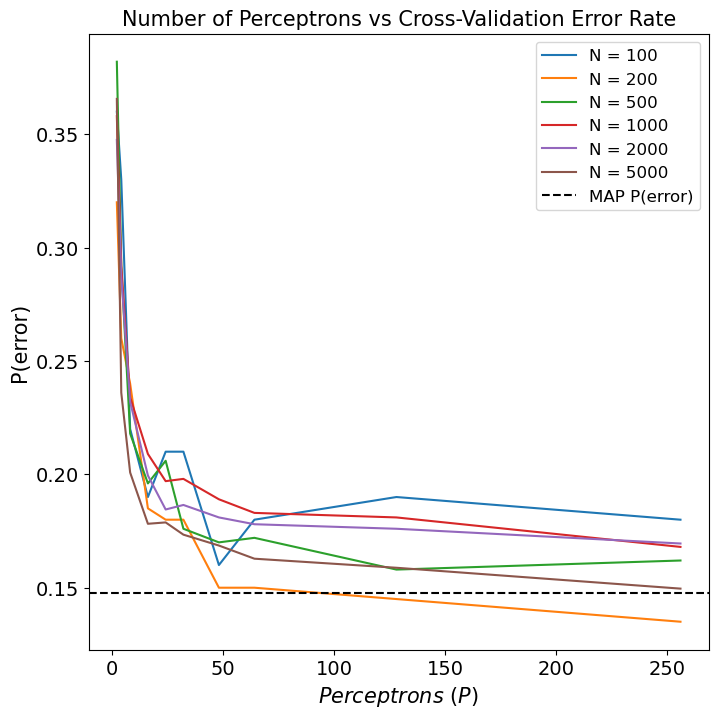

In [13]:
# 10-Fold Cross-Validation (k=10)
k = 10
numPerceptrons = [2, 4, 8, 16, 24, 32, 48, 64, 128, 256]
# List of best number of perceptrons each training set
P_best_values = []

# Create figure for plotting # of Perceptrons vs Cross-Validation
fig, ax = plt.subplots(figsize=(8, 8))

print("\t# of Training Samples \tBest # of Perceptrons \t P(error)")
for i in range(len(X_train)):
    P_best, P_CV_err = k_fold_compute_P(k, numPerceptrons, X_train[i], y_train[i])
    P_best_values.append(P_best)
    print("\t\t %d \t\t\t %d \t\t  %.3f" % (N_train[i], P_best, np.min(P_CV_err)))
    ax.plot(numPerceptrons, P_CV_err, label="N = {}".format(N_train[i]))

plt.axhline(y=min_prob_error, color="black", linestyle="--", label="MAP P(error)")
ax.set_title("Number of Perceptrons vs Cross-Validation Error Rate")
ax.set_xlabel(r"$Perceptrons \ (P)$")
ax.set_ylabel("P(error)")
ax.legend()
plt.show()


Based on the downward trends of the above graph, most of the cross-validation results of the datasets start to level out around $P=128$. In particular, the datasets for $N>1000$ serve as a better indication of the true data pdf so their results hold more weight in the decision for best number of perceptrons. The smaller datasets, especially $N=200$ was able to out-perform the theoretically optimal error rate of $0.1476$ which is very misleading to trust the results for the smaller datasets. So the best # of perceptrons seems to be around $\hat{P}=128$

### **Model Training**

 For each training set, having identified the best number of perceptrons using
cross-validation, using maximum likelihood parameter estimation (minimum cross-entropy loss)
train an MLP using each training set with as many perceptrons as you have identified as optimal
for that training set. These are your final trained MLP models for class posteriors (possibly each
with different number of perceptrons and different weights). Make sure to mitigate the chances
of getting stuck at a local optimum by randomly reinitializing each MLP training routine multiple
times and getting the highest training-data log-likelihood solution you encounter.

In [16]:
# List of trained MlPs for later testing
trained_MLPs = []
# Number of times to re-train same model to mitigate getting stuck at local optimum
numRetrains = 10

for i in range(len(X_train)):
    # Convert training samples into Tensor datatypes 
    X_i = torch.FloatTensor(X_train[i])
    y_i = torch.LongTensor(y_train[i])
    
    retrain_MLPs = []
    retrain_losses = []
    # Retrain models 10 times to mitigate getting stuck at local optimum
    for r in range(numRetrains):
        # Use 2-Layer MLP as defined earlier using Tensor Training Samples and Best P values
        model = TwoLayerMLP(X_i.shape[1], P_best_values[i], C)
        # Optimize with Stochastic Gradient Descent on model parameters
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        # Retrieve retrained model and loss tensor classes 
        model, loss = model_train(model, X_i, y_i, optimizer)
        retrain_MLPs.append(model)
        retrain_losses.append(loss.detach().item())

    # Find model with minimized losses from retraining iterations and append to final list of trained models
    trained_MLPs.append(retrain_MLPs[np.argmin(retrain_losses)])
    print("Training for N = {} Complete".format(X_train[i].shape[0]))

Training for N = 100 Complete
Training for N = 200 Complete
Training for N = 500 Complete
Training for N = 1000 Complete
Training for N = 2000 Complete
Training for N = 5000 Complete


### **Performance Assessment**

 Using each trained MLP as a model for class posteriors, and using
the MAP decision rule (aiming to minimize the probability of error) classify the samples in the test
set and for each trained MLP empirically estimate the probability of error.

	 # of Training Samples 	  P(error)
		 100 		   0.191
		 200 		   0.174
		 500 		   0.169
		 1000 		   0.163
		 2000 		   0.158
		 5000 		   0.157


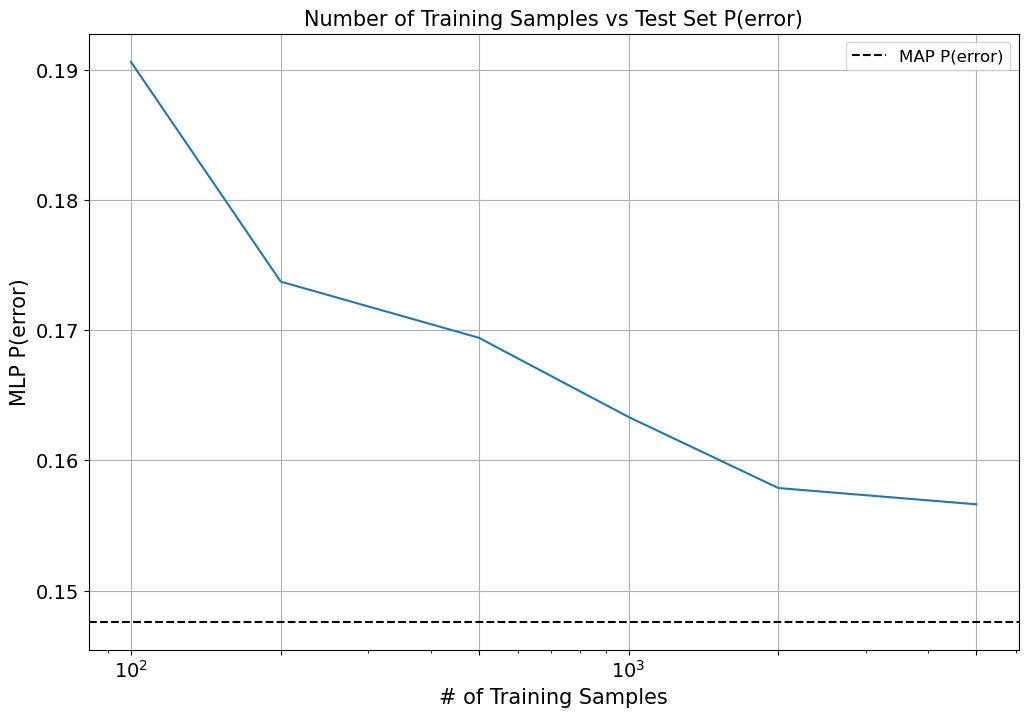

In [47]:
# Convert testing samples into Tensor datatypes
X_test_tensor = torch.FloatTensor(X_test)
# allocate memory for P(error) list
Perror_list = []

# Plot for 
fig, ax = plt.subplots(figsize=(12, 8))

# Estimate loss (probability of error) for each trained MLP model by testing on the test data set
print("\t # of Training Samples \t  P(error)")
for i in range(len(X_train)):
    # Evaluate the neural network on the test set
    predictions = model_predict(trained_MLPs[i], X_test_tensor)
    # Compute the probability of error estimates
    prob_error = np.sum(predictions != y_test) / len(y_test)
    print("\t\t %d \t\t   %.3f" % (N_train[i], prob_error))
    Perror_list.append(prob_error)

plt.axhline(y=min_prob_error, color="black", linestyle="--", label="MAP P(error)")
ax.semilogx(N_train, Perror_list)
ax.set_title("Number of Training Samples vs Test Set P(error)")
ax.set_xlabel("# of Training Samples")
ax.set_ylabel("MLP P(error)")
ax.set_xticks(N_train)
ax.legend()
ax.grid()
plt.show()

As we can see from the above plot, the empirically estimated P(error) decreases as the # of training samples in the training sets increases towards the theoretically optimal min P(error). This was to be anticipated since the larger number of training samples vastly indicates the true data pdf in the larger training sample sizes than the smaller sets. The best performance came from the $N=5000$ training set which achieved an empirical P(error) = $0.157$. This result is only a 0.01 difference from the theoretically optimal P(error) and we could assume that if we continued to train with larger datasets, this theoretically optimal value would contrinue to be approached. 

## Question 2  

Conduct following model order selection exercise using 10-fold cross-validation procedure and report your procedure and results

### Specify Gaussian Mixture Model consisting of 4 components made-up of 2D real-valued data with different mean vectors, covariances, and weights

Gaussian Parameters are described below

Mean Vectors and Covariance Matrices:
$$ 

\begin{align*} \boldsymbol{\mu}_0 = \begin{bmatrix} -3\\ 0\\0 \end{bmatrix} \quad \quad \boldsymbol{\Sigma}_0 =\begin{bmatrix}1 & 0.5\\ 0.5 & 1\end{bmatrix} \quad & \quad \boldsymbol{\mu}_1 =\begin{bmatrix}-1\\0\\0\end{bmatrix} \quad \quad \boldsymbol{\Sigma}_1 =\begin{bmatrix}1 & -0.25 \\  -0.25 & 1\end{bmatrix} \\ \boldsymbol{\mu}_2 =\begin{bmatrix}1\\0\\0\end{bmatrix} \quad \quad \boldsymbol{\Sigma}_2 =\begin{bmatrix}1 & 0.4 \\ 0.4 & 1\end{bmatrix} \quad & \quad \boldsymbol{\mu}_3 = \ \begin{bmatrix}3\\0\\0\end{bmatrix} \quad \quad \ \ \ \boldsymbol{\Sigma}_3 =\begin{bmatrix}1 & -0.4 \\ -0.4 & 1\end{bmatrix} \end{align*}
$$

Classes Priors are:
$$
P(C_0) = 0.15 \quad P(C_1) = 0.4 \quad P(C_2) = 0.2 \quad P(C_3) = 0.25
$$

### Generate Gaussian Mixture Model consisting of 4 components made-up of 2D real-valued data with different mean vectors, covariances, and weights

In [57]:
# Number of classes
C = 4
# Create dict that will hold GMM parameters
gmm_pdf = {}
# Class priors need to all be different
gmm_pdf['priors'] = [0.15, 0.4, 0.2, .25]  # uniform prior
num_classes = len(gmm_pdf['priors'])
# Gaussian distributions means are all different
gmm_pdf['mu'] = np.array([[-3, 0],
                         [-1, 0],
                         [1, 0],
                         [3, 0]])  
# Gaussian distributions covariance matrices are all different as well
gmm_pdf['Sigma'] = np.array([[[1, .5],
                              [.5, 1]],
                             [[1, -.25],
                              [-.25, 1]],
                             [[1, .4],
                              [.4, 1]],
                             [[1, -.4],
                              [-.4, 1]]])  

### Generate Multiple datasets with i.i.d. samples using true GMM; Datasets have 10, 100, 1000, and 10000 samples

Generating the training data set; Ntrain = 10
Generating the training data set; Ntrain = 100
Generating the training data set; Ntrain = 1000
Generating the training data set; Ntrain = 10000


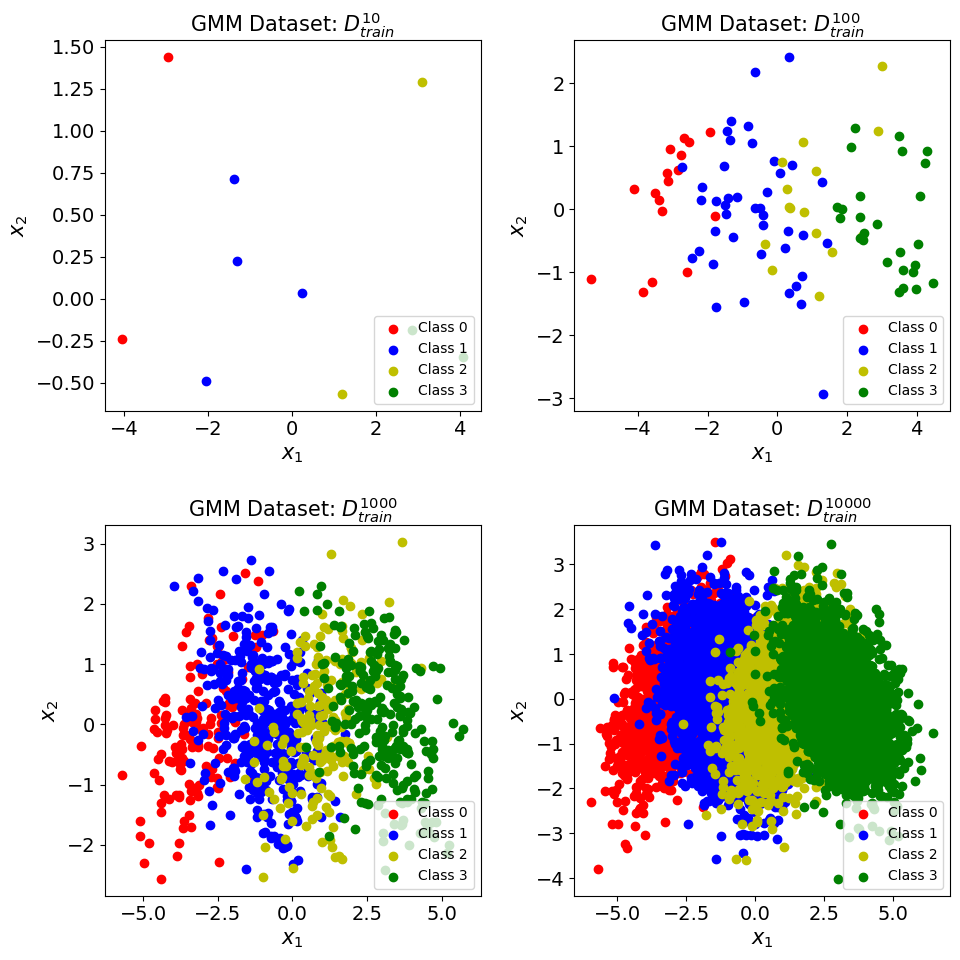

In [123]:
# Number of training input samples for experiments
N_train = [10, 100, 1000, 10000]
# Number of test samples for experiments
N_test = 100000

# Lists to hold the corresponding input matrices, target vectors and sample label counts per training set
X_train = []
labels_train = []
for N_i in N_train:
    print("Generating the training data set; Ntrain = {}".format(N_i))
    
    # Modulus to plot in right locations, hacking it
    X_i, labels_i = generate_gmm(N_i, gmm_pdf)

    # Add to lists
    X_train.append(X_i)
    labels_train.append(labels_i)

# Plot the original data and their true labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# Plot GMM 10 dataset with correct class labels
ax[0, 0].scatter(X_train[0][labels_train[0] == 0, 0], X_train[0][labels_train[0] == 0, 1], c='r', label="Class 0")
ax[0, 0].scatter(X_train[0][labels_train[0] == 1, 0], X_train[0][labels_train[0] == 1, 1], c='b', label="Class 1")
ax[0, 0].scatter(X_train[0][labels_train[0] == 2, 0], X_train[0][labels_train[0] == 2, 1], c='y', label="Class 2")
ax[0, 0].scatter(X_train[0][labels_train[0] == 3, 0], X_train[0][labels_train[0] == 3, 1], c='g', label="Class 3")
ax[0, 0].set_title(r"GMM Dataset: $D^{%d}_{train}$" % (N_train[0]))
ax[0, 0].set_xlabel(r"$x_1$")
ax[0, 0].set_ylabel(r"$x_2$")
ax[0, 0].legend(loc = 'lower right', fontsize = 10)
# Plot GMM 100 dataset with correct class labels
ax[0, 1].scatter(X_train[1][labels_train[1] == 0, 0], X_train[1][labels_train[1] == 0, 1], c='r', label="Class 0")
ax[0, 1].scatter(X_train[1][labels_train[1] == 1, 0], X_train[1][labels_train[1] == 1, 1], c='b', label="Class 1")
ax[0, 1].scatter(X_train[1][labels_train[1] == 2, 0], X_train[1][labels_train[1] == 2, 1], c='y', label="Class 2")
ax[0, 1].scatter(X_train[1][labels_train[1] == 3, 0], X_train[1][labels_train[1] == 3, 1], c='g', label="Class 3")
ax[0, 1].set_title(r"GMM Dataset: $D^{%d}_{train}$" % (N_train[1]))
ax[0, 1].set_xlabel(r"$x_1$")
ax[0, 1].set_ylabel(r"$x_2$")
ax[0, 1].legend(loc = 'lower right', fontsize = 10)
# Plot GMM 1000 dataset with correct class labels
ax[1, 0].scatter(X_train[2][labels_train[2] == 0, 0], X_train[2][labels_train[2] == 0, 1], c='r', label="Class 0")
ax[1, 0].scatter(X_train[2][labels_train[2] == 1, 0], X_train[2][labels_train[2] == 1, 1], c='b', label="Class 1")
ax[1, 0].scatter(X_train[2][labels_train[2] == 2, 0], X_train[2][labels_train[2] == 2, 1], c='y', label="Class 2")
ax[1, 0].scatter(X_train[2][labels_train[2] == 3, 0], X_train[2][labels_train[2] == 3, 1], c='g', label="Class 3")
ax[1, 0].set_title(r"GMM Dataset: $D^{%d}_{train}$" % (N_train[2]))
ax[1, 0].set_xlabel(r"$x_1$")
ax[1, 0].set_ylabel(r"$x_2$")
ax[1, 0].legend(loc = 'lower right', fontsize = 10)
# Plot GMM 10000 dataset with correct class labels
ax[1, 1].scatter(X_train[3][labels_train[3] == 0, 0], X_train[3][labels_train[3] == 0, 1], c='r', label="Class 0")
ax[1, 1].scatter(X_train[3][labels_train[3] == 1, 0], X_train[3][labels_train[3] == 1, 1], c='b', label="Class 1")
ax[1, 1].scatter(X_train[3][labels_train[3] == 2, 0], X_train[3][labels_train[3] == 2, 1], c='y', label="Class 2")
ax[1, 1].scatter(X_train[3][labels_train[3] == 3, 0], X_train[3][labels_train[3] == 3, 1], c='g', label="Class 3")
ax[1, 1].set_title(r"GMM Dataset: $D^{%d}_{train}$" % (N_train[3]))
ax[1, 1].set_xlabel(r"$x_1$")
ax[1, 1].set_ylabel(r"$x_2$")
ax[1, 1].legend(loc = 'lower right', fontsize = 10)
# Using largest dataset samples set the limit axes for all subplots
plt.tight_layout()
plt.show()

### Perform EM Algorithm with K-Fold Cross-Validation and evaluate GMM with model orders = {1,2,3,4,5,6}

In [124]:
# Perform Repeated 10-fold Cross-Validation up to 30 times
cv = KFold(n_splits=10, shuffle = True, random_state=42)

### EM Algorithm for GMM 10 Dataset

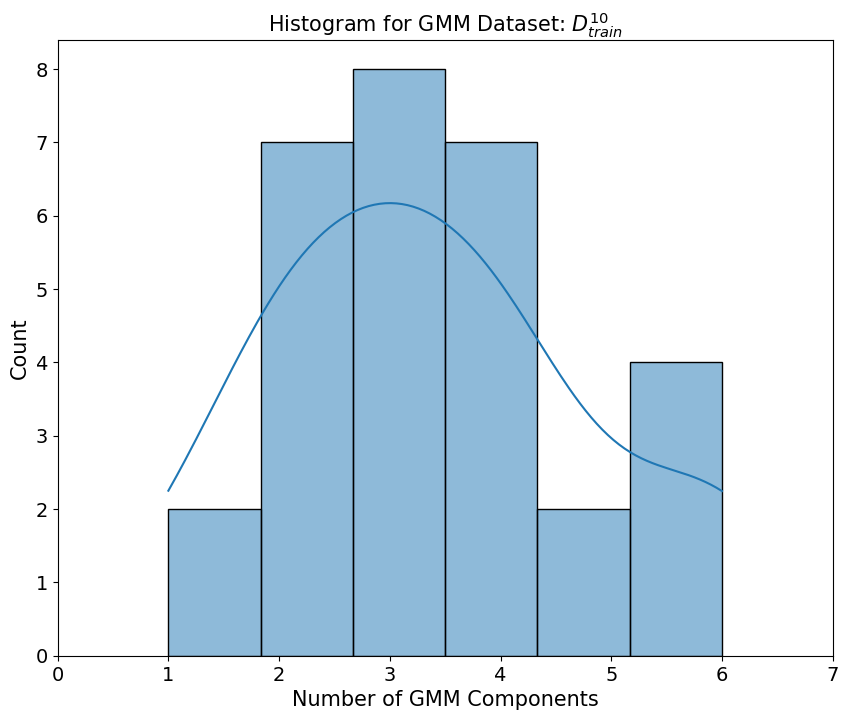

In [126]:
# Use EM Algorithm and GaussianMixture object to estimate the MLE parameters for each dataset
# Use loop to check each GMM with model orders {1,2,3,4,5,6} and estimate model parameters with EM algorithm
best_score = []
for i in range(1,31):
    best_score_sum = 0
    best_score_n_comps = 0
    loop_score = []
    for j in range(1,7):
        scores = cross_val_predict(GaussianMixture(n_components = j, n_init = 10,init_params='kmeans'),X_train[0],labels_train[0],cv=cv,n_jobs=-1)
        # report performance
        correct_pred_sum = compute_accuracy(scores,labels_train[0])
        loop_score.append(correct_pred_sum)
        if (correct_pred_sum > best_score_sum):
            best_score_sum = correct_pred_sum
            best_score_n_comps = j
    #print(loop_score)
    best_score.append(best_score_n_comps)

# Plot Histogram showing # of Components selected
figure(figsize=(10,8))
sns.histplot(data=best_score,kde=True)
plt.title(r'Histogram for GMM Dataset: $D^{%d}_{train}$' % (N_train[0]))
plt.xlabel('Number of GMM Components')
plt.xlim(0, 7)
plt.show()

After iterating 30 times through a 10-Fold Cross-Validation of estimating the GMM Model Order using the EM algorithm, the above histogram was computed. We can see that Model Order of 3 components was selected 8 times out of the 30 iterations when estimating on the 10 samples training set. Since this is the smallest dataset, the samples for the true data pdf were fairly separated or at least did not have a great number of samples clustered on top of one another, which allowed the EM algorithm to compute close to the true number of Gaussian Components.

### EM Algorithm for GMM 100 Dataset

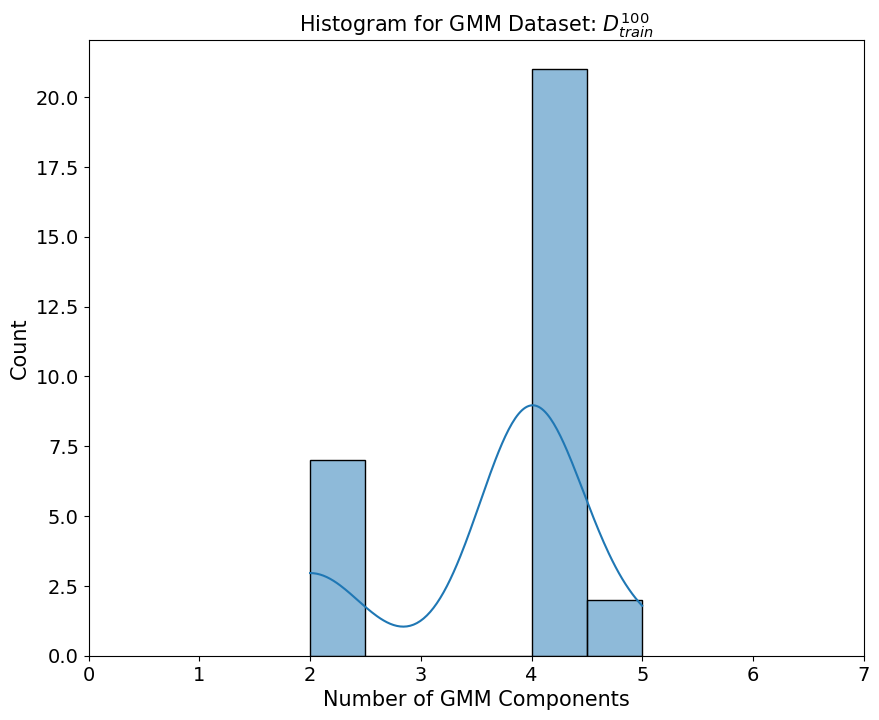

In [127]:
# Use EM Algorithm and GaussianMixture object to estimate the MLE parameters for each dataset
# Use loop to check each GMM with model orders {1,2,3,4,5,6} and estimate model parameters with EM algorithm
best_score = []
for i in range(1,31):
    best_score_sum = 0
    best_score_n_comps = 0
    loop_score = []
    for j in range(1,7):
        scores = cross_val_predict(GaussianMixture(n_components = j, n_init = 10,init_params='kmeans'),X_train[1],labels_train[1],cv=cv,n_jobs=-1)
        # report performance
        correct_pred_sum = compute_accuracy(scores,labels_train[1])
        loop_score.append(correct_pred_sum)
        if (correct_pred_sum > best_score_sum):
            best_score_sum = correct_pred_sum
            best_score_n_comps = j
    #print(loop_score)
    best_score.append(best_score_n_comps)

# Plot Histogram showing # of Components selected
figure(figsize=(10,8))
sns.histplot(data=best_score,kde=True)
plt.title(r'Histogram for GMM Dataset: $D^{%d}_{train}$' % (N_train[1]))
plt.xlabel('Number of GMM Components')
plt.xlim(0, 7)
plt.show()

Again iterating 30 times through a 10-Fold Cross-Validation of estimating the GMM Model Order using the EM algorithm, the above histogram was computed. We can see that Model Order of 4 components was selected over 20 times out of the 30 iterations when estimating on the 100 samples training set, which was a better estimate than the previous dataset. 

### EM Algorithm for GMM 1,000 Dataset

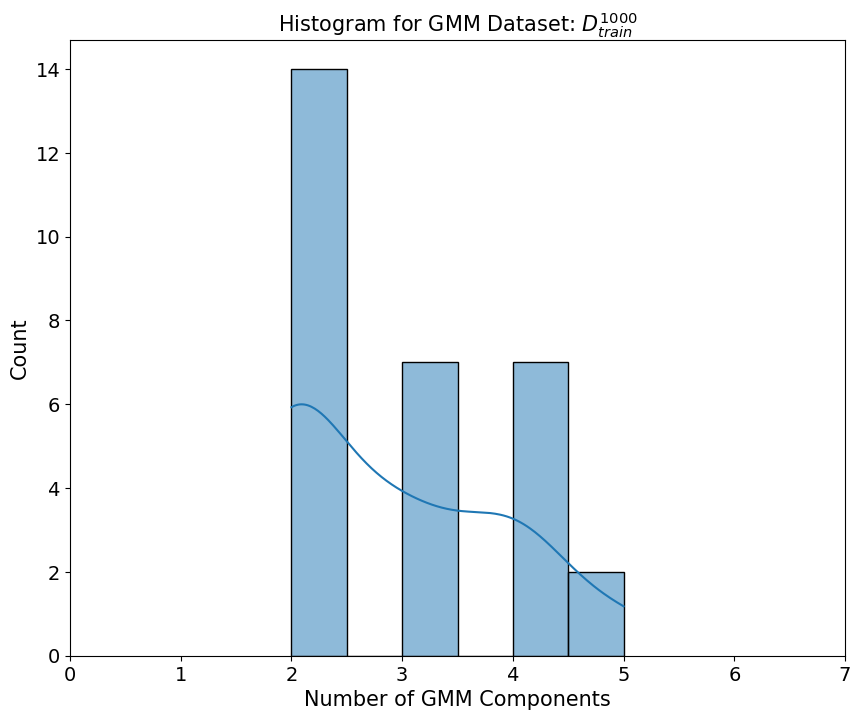

In [130]:
# Use EM Algorithm and GaussianMixture object to estimate the MLE parameters for each dataset
# Use loop to check each GMM with model orders {1,2,3,4,5,6} and estimate model parameters with EM algorithm
best_score = []
for i in range(1,31):
    best_score_sum = 0
    best_score_n_comps = 0
    loop_score = []
    for j in range(1,7):
        scores = cross_val_predict(GaussianMixture(n_components = j, n_init = 10,init_params='kmeans'),X_train[2],labels_train[2],cv=cv,n_jobs=-1)
        # report performance
        correct_pred_sum = compute_accuracy(scores,labels_train[2])
        loop_score.append(correct_pred_sum)
        if (correct_pred_sum > best_score_sum):
            best_score_sum = correct_pred_sum
            best_score_n_comps = j
    #print(loop_score)
    best_score.append(best_score_n_comps)

# Plot Histogram showing # of Components selected
figure(figsize=(10,8))
sns.histplot(data=best_score,kde=True)
plt.title(r'Histogram for GMM Dataset: $D^{%d}_{train}$' % (N_train[2]))
plt.xlabel('Number of GMM Components')
plt.xlim(0, 7)
plt.show()

Again iterating 30 times through a 10-Fold Cross-Validation of estimating the GMM Model Order using the EM algorithm, the above histogram for Model Order Selection for the 1000 Training samples. We can see that Model Order of 2 components was selected 14 times out of the 30 iterations. Judging by the true data pdf in the previous section, we see that alot of the sample point are clustered together and based on that distribution the EM Algorithm trended towards the Gaussian Mixture being composed of 2 components instead of the true number of components being 4.  

### EM Algorithm for GMM 10,000 Dataset

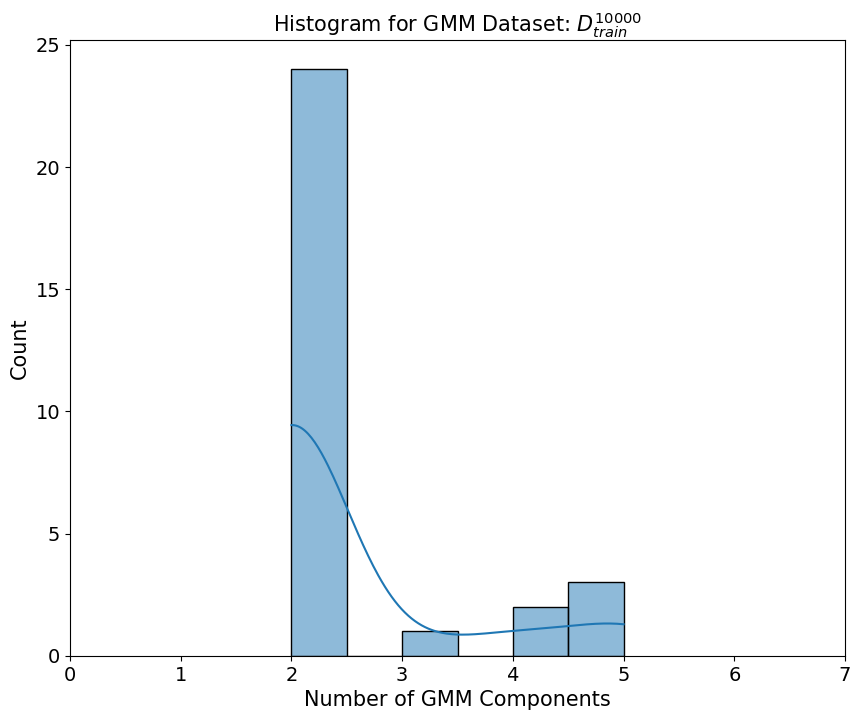

In [131]:
# Use EM Algorithm and GaussianMixture object to estimate the MLE parameters for each dataset
# Use loop to check each GMM with model orders {1,2,3,4,5,6} and estimate model parameters with EM algorithm
best_score = []
for i in range(1,31):
    best_score_sum = 0
    best_score_n_comps = 0
    loop_score = []
    for j in range(1,7):
        scores = cross_val_predict(GaussianMixture(n_components = j, n_init = 10,init_params='kmeans'),X_train[3],labels_train[3],cv=cv,n_jobs=-1)
        # report performance
        correct_pred_sum = compute_accuracy(scores,labels_train[3])
        loop_score.append(correct_pred_sum)
        if (correct_pred_sum > best_score_sum):
            best_score_sum = correct_pred_sum
            best_score_n_comps = j
    #print(loop_score)
    best_score.append(best_score_n_comps)

# Plot Histogram showing # of Components selected
figure(figsize=(10,8))
sns.histplot(data=best_score,kde=True)
plt.title(r'Histogram for GMM Dataset: $D^{%d}_{train}$' % (N_train[3]))
plt.xlabel('Number of GMM Components')
plt.xlim(0, 7)
plt.show()

For the last 30 iterations of 10-Fold Cross-Validation of estimating the GMM Model Order using the EM algorithm, the above histogram for Model Order Selection for the 10,000 Training samples. We can see that Model Order of 2 components was selected again, but now it was selected 24 times out of the 30 iterations. Again, judging by the true data pdf in the previous section, we see that alot of the samples are clustered together even more in a denser cluster due to the order of magnitude more than the previous histogram. The EM Algorithm trended towards the Gaussian Mixture being composed of 2 components instead of the true number of components being 4. I believe this result is from how close the GMM parameters for the 4 components are for each other. I believe if I made the parameters more separated, the Model Order Selection would trend towards the true number of components. 

# Appendix

## Code

### Imports


In [ ]:
# Import Plotting modules matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# import math, numpy, and pandas
from numpy import mean, std
import numpy as np
import pandas as pd
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show, semilogx, xticks

# import scipy module
from scipy.stats import norm, multivariate_normal as mvn

# import sklearn module
from sklearn.model_selection import KFold 
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.mixture import GaussianMixture
from sklearn import metrics

# import pytorch module
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torchsummary import summary

np.random.seed(7)
np.set_printoptions(suppress=True)
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=20)   # fontsize of the figure title


### Data-Generating Functions


In [ ]:
def generate_gmm(N, pdf_params):
    # Use mean vectors to determine dimensionality of data
    d = pdf_params['mu'].shape[1]
    # Output samples and labels
    X = np.zeros([N, d])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component
    u = np.random.rand(N)
    # Determine thresholds based on the mixture weights/priors for the GMM
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(len(pdf_params['priors'])))
    for l in L:
        # Get randomly sampled indices for this component
        idx = np.argwhere((thresholds[l] <= u) & (u <= thresholds[l+1]))[:, 0]
        # No. of samples in this component
        N_labels = len(idx)  
        labels[idx] = l * np.ones(N_labels)
        X[idx, :] =  mvn.rvs(pdf_params['mu'][l], pdf_params['Sigma'][l], N_labels)
    
    return X, labels

### Evaluation Functions

In [ ]:
def compute_accuracy(predictions,labels):
    return sum(predictions == labels)

## Reference Sources

1. https://pytorch.org/docs/stable/nn.html#
2. https://medium.com/biaslyai/pytorch-introduction-to-neural-network-feedforward-neural-network-model-e7231cff47cb
3. https://neuralthreads.medium.com/softplus-function-smooth-approximation-of-the-relu-function-6a85f92a98e6
4. https://towardsdatascience.com/gmm-gaussian-mixture-models-how-to-successfully-use-it-to-cluster-your-data-891dc8ac058f
5. https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html